# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Apply transformations to handle skewness and normalize distributions.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv`
* Trained pipeline: outputs/pipelines/feature_pipeline_cleaned.pkl.
* Feature order file: outputs/pipelines/feature_order.txt.
* Visualizations: Charts showing correlations, feature importance, and relationships with SalePrice.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

##### Import necessary libraries and csv for data analysis, preprocessing, and modeling.

## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from joblib import dump, load


df_cleaned = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
df_cleaned.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,548.0,RFn,2003.0,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,460.0,RFn,1976.0,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,608.0,RFn,2001.0,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500.0
3,961.0,0.0,3.0,No,216.0,ALQ,540.0,642.0,Unf,1998.0,...,9550.0,60.0,0.0,35.0,5,7,756.0,1915,1970,140000.0
4,1145.0,0.0,4.0,Av,655.0,GLQ,490.0,836.0,RFn,2000.0,...,14260.0,84.0,350.0,84.0,5,8,1145.0,2000,2000,250000.0


___

##### Check data types to verify that all columns are correctly loaded. This helps ensure that numerical and categorical features are properly identified and ready for preprocessing.

In [6]:
df_cleaned.dtypes

1stFlrSF        float64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinType1     object
BsmtUnfSF       float64
GarageArea      float64
GarageFinish     object
GarageYrBlt     float64
GrLivArea       float64
KitchenQual      object
LotArea         float64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF     float64
OverallCond       int64
OverallQual       int64
TotalBsmtSF     float64
YearBuilt         int64
YearRemodAdd      int64
SalePrice       float64
dtype: object

___

##### Plot the correlation matrix to quickly see which features have a strong correlation with SalePrice. This helps identify the most important predictors before feature engineering.

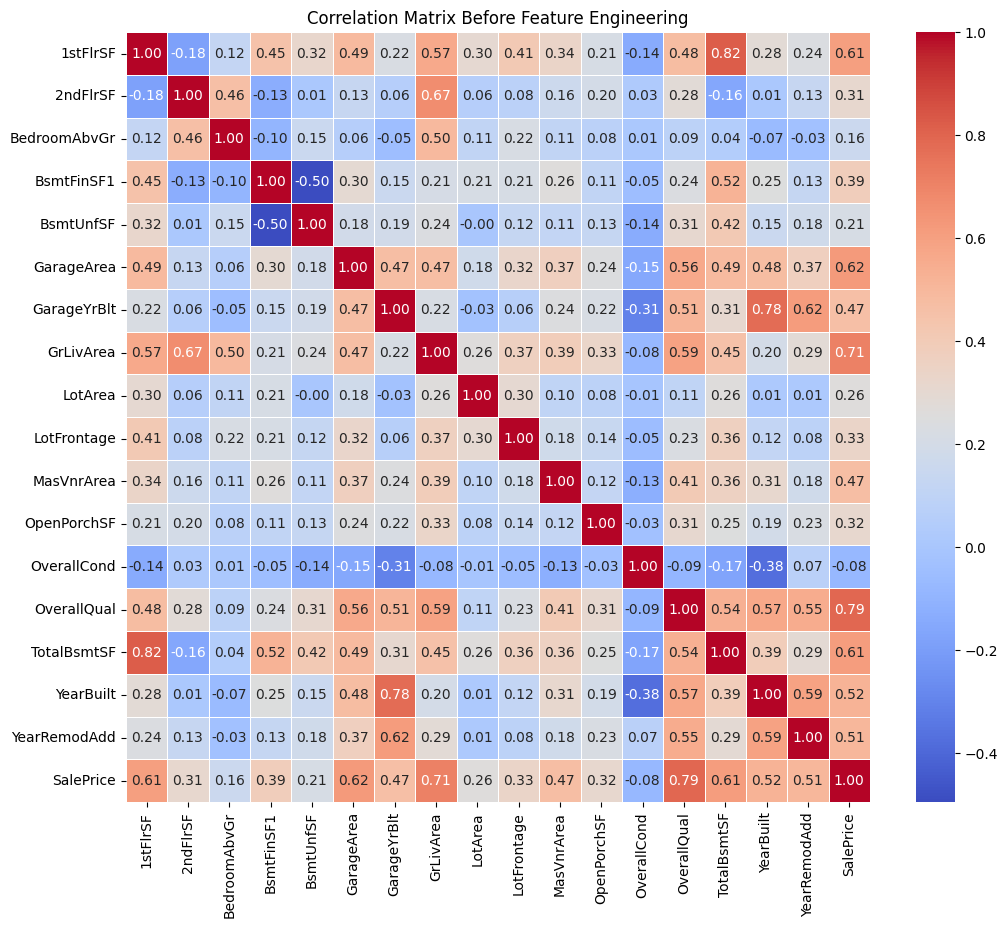

In [7]:
# Show the correlation matrix before feature engineering
correlation_matrix_before = df_cleaned.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()

##### **Correlation Matrix Before Feature Engineering**

The correlation matrix helps see how features relate to the target **SalePrice** before starting the feature engineering process. This helps decide which features are important and which can be combined or removed to make the model better.

**Key Insights:**

* **GrLivArea (0.71)** and **OverallQual (0.79)** have strong positive links to "SalePrice," making them important predictors.

* **GarageArea (0.62)** and **TotalBsmtSF (0.61)** also have strong positive links, showing that bigger garages and basements add value to house prices.

* **BedroomAbvGr (0.16)** and **OverallCond (-0.08)** have weak links to "SalePrice". These may be improved.

___

##### Remove features with negative correlation to SalesPrice since they don´t offer any value to the model.

In [8]:
# Filter features with negative correlation with SalePrice
negative_corr_features = correlation_matrix_before['SalePrice'][correlation_matrix_before['SalePrice'] < 0].index.tolist()

# Print features with negative correlations
print("Features with negative correlation to SalePrice:")
print(negative_corr_features)

# Remove these features from the cleaned dataset
df_cleaned = df_cleaned.drop(columns=negative_corr_features)
print(f"Dataset shape after removing negative correlation features: {df_cleaned.shape}")

Features with negative correlation to SalePrice:
['OverallCond']
Dataset shape after removing negative correlation features: (1460, 21)


___

##### This function applies and visualizes transformations (Log, Box-Cox, Yeo-Johnson) on a variable during EDA.
**Purpose:**
- Fix skewness and make the data more normal for better model performance.
- Compare transformations using histograms, QQ-plots, and boxplots.

**Output:**
- Helps choose the best transformation for the variable.


In [9]:
def compare_transformations(df, variable):
    """
    Perform and visualize various transformations for a specific variable during EDA.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the variable.
    - variable (str): The name of the variable to analyze.
    
    Returns:
    None. Displays histograms, QQ-plots, and boxplots for various transformations.
    """
    original = df[variable].dropna()  # Handle NaN values

    # Shift negative values for Box-Cox
    if original.min() <= 0:
        shift_value = abs(original.min()) + 1
        print(f"Shifting {variable} by {shift_value} for Box-Cox transformation.")
        original += shift_value

    # Apply transformations
    transformations = {
        "Original": original,
        "Log": np.log1p(original),
        "Box-Cox": BoxCoxTransformer(variables=[variable]).fit_transform(original.to_frame())[variable],
        "Yeo-Johnson": YeoJohnsonTransformer(variables=[variable]).fit_transform(original.to_frame())[variable]
    }

    # Plot results
    fig, axes = plt.subplots(len(transformations), 3, figsize=(15, 5 * len(transformations)))
    fig.suptitle(f"Transformation Analysis for {variable}", fontsize=16, y=1.02)
    
    for i, (name, transformed) in enumerate(transformations.items()):
        # Histogram
        axes[i, 0].hist(transformed, bins=30, alpha=0.7)
        axes[i, 0].set_title(f"{name} - Histogram")
        
        # QQ-plot
        stats.probplot(transformed, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title("QQ-Plot")
        
        # Boxplot
        axes[i, 2].boxplot(transformed, vert=False)
        axes[i, 2].set_title("Boxplot")
    
    plt.tight_layout()
    plt.show()

##### Print histogram, QQ-plot, and boxplot results for each strongly correlated variable. Helps visualize the effects of transformations on data distribution.

Analyzing transformations for: GrLivArea


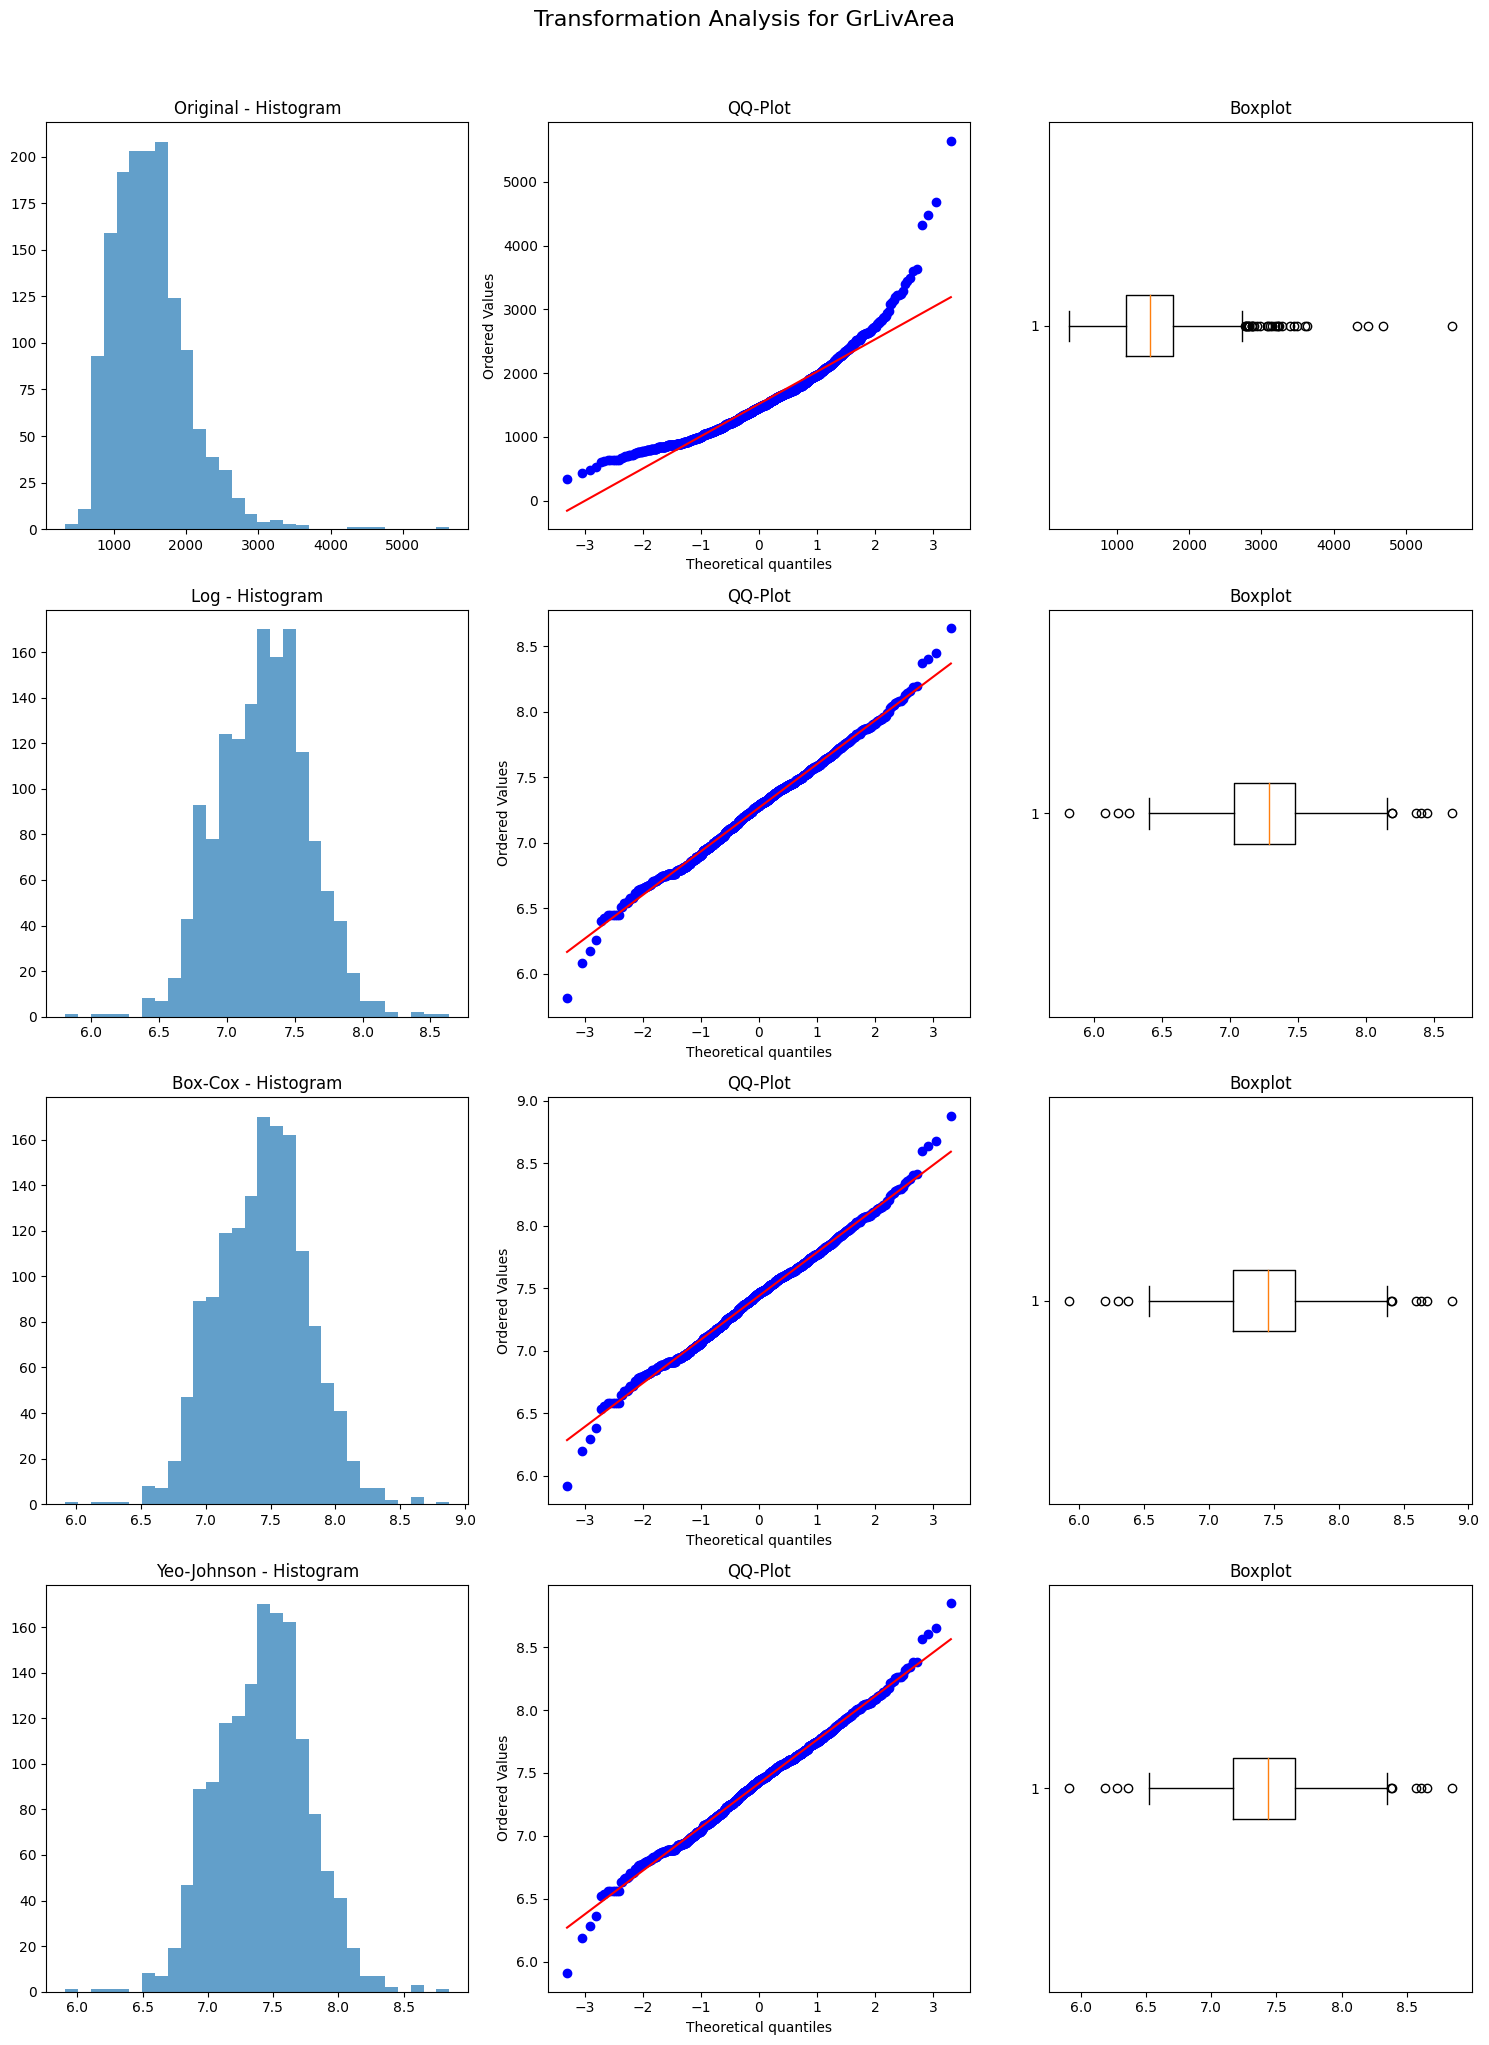

Analyzing transformations for: OverallQual


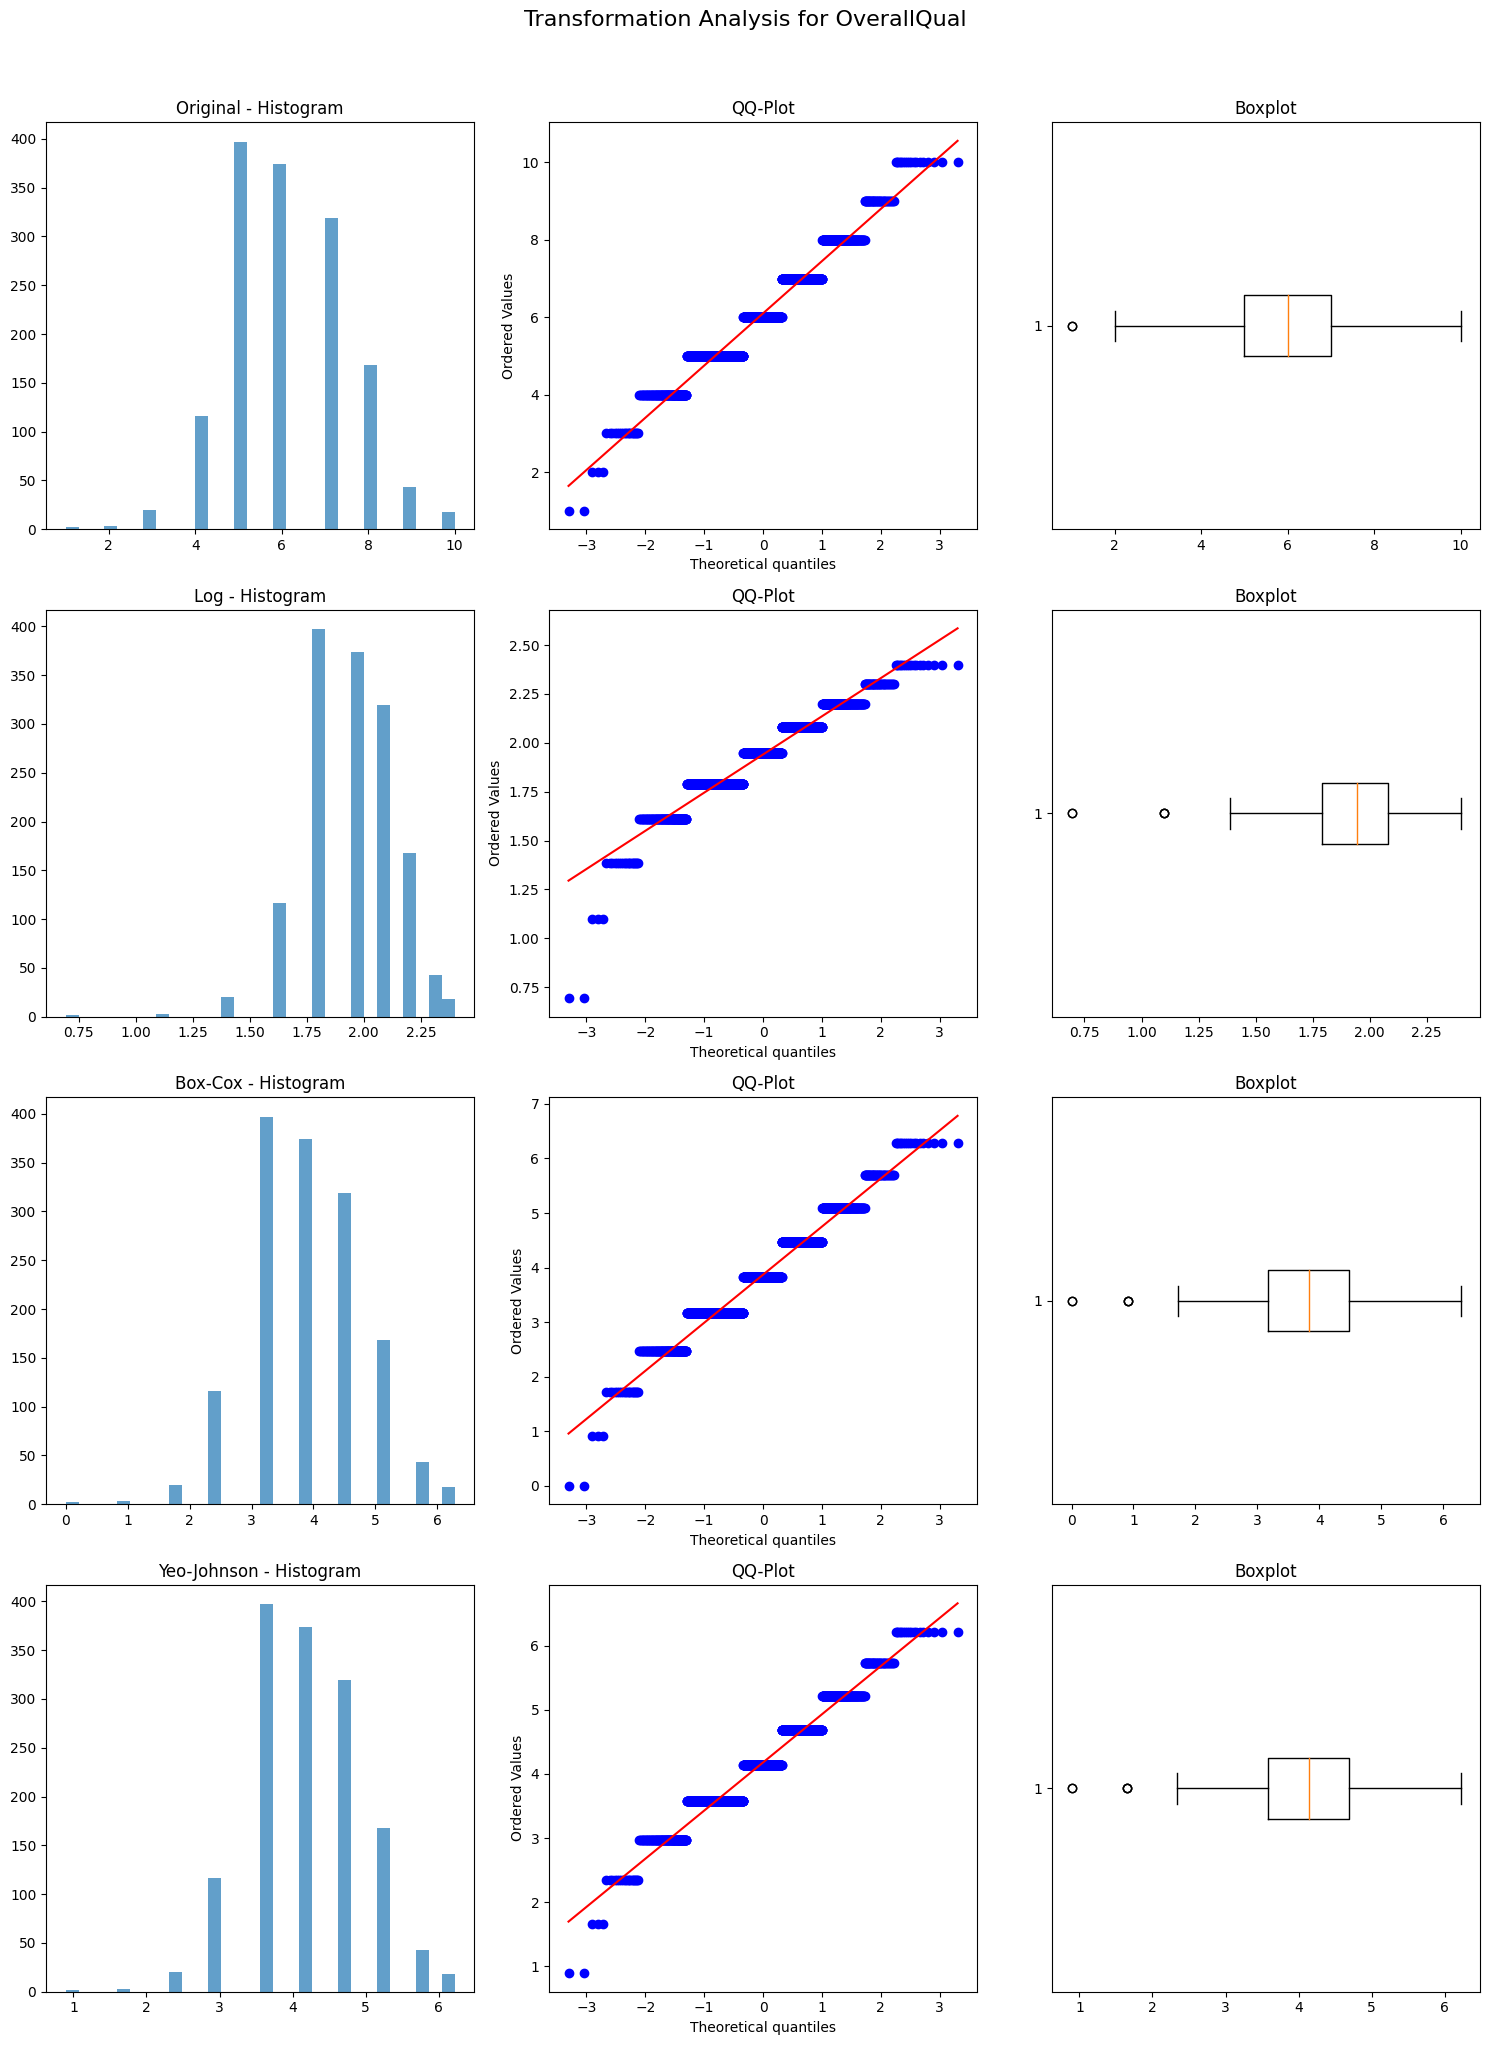

Analyzing transformations for: GarageArea
Shifting GarageArea by 1.0 for Box-Cox transformation.


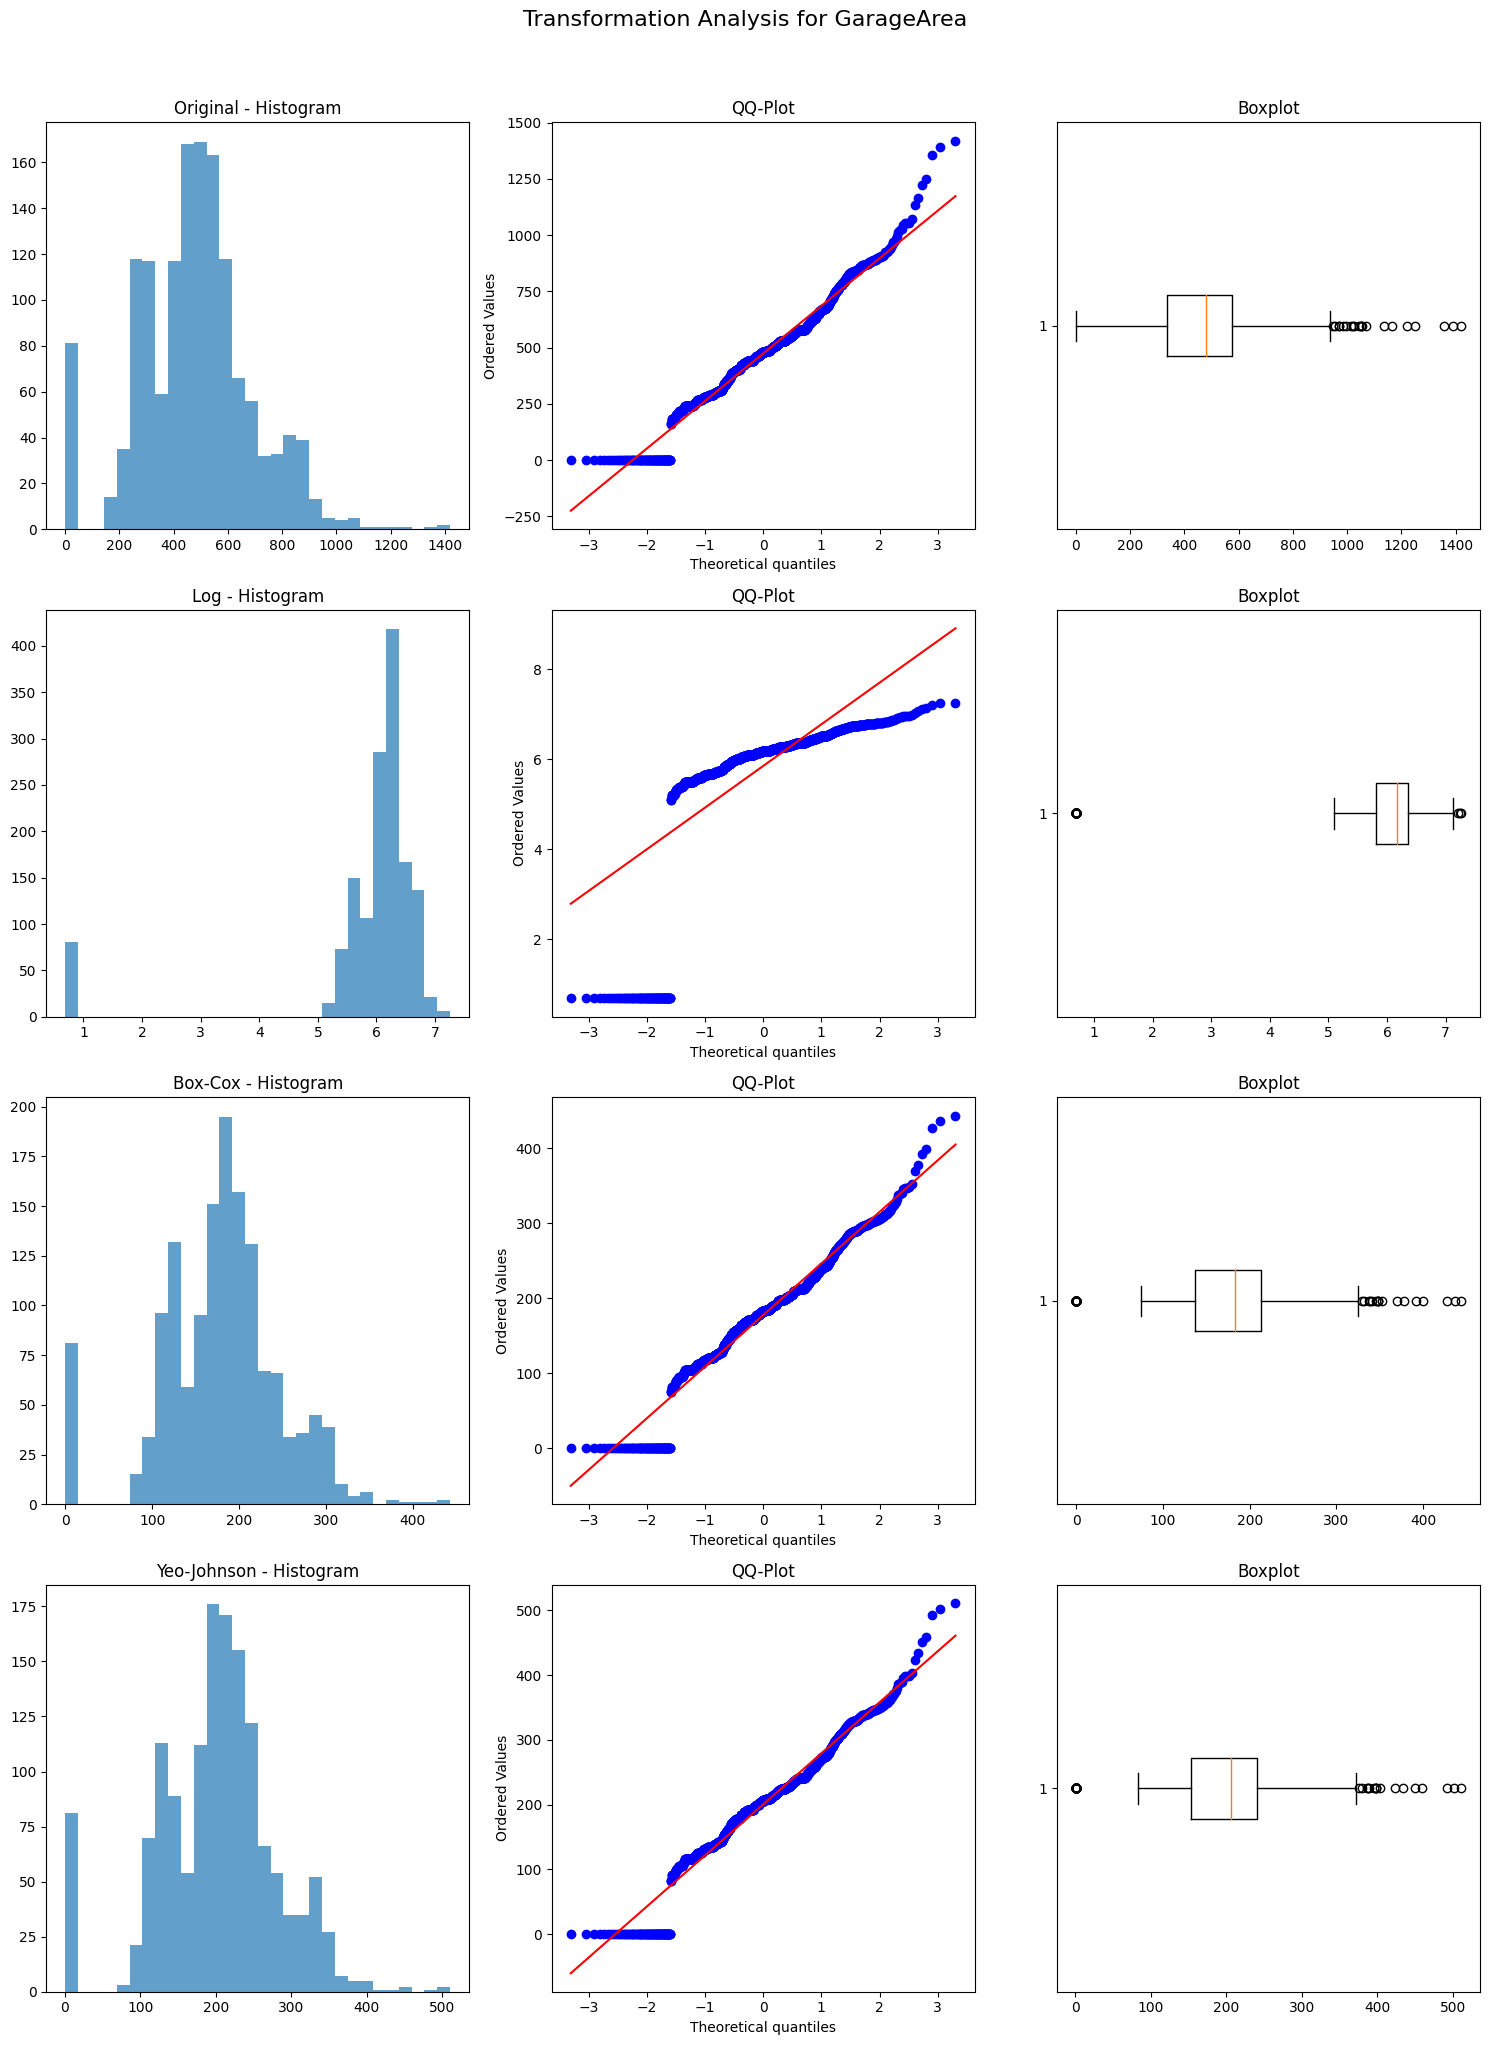

Analyzing transformations for: TotalBsmtSF
Shifting TotalBsmtSF by 1.0 for Box-Cox transformation.


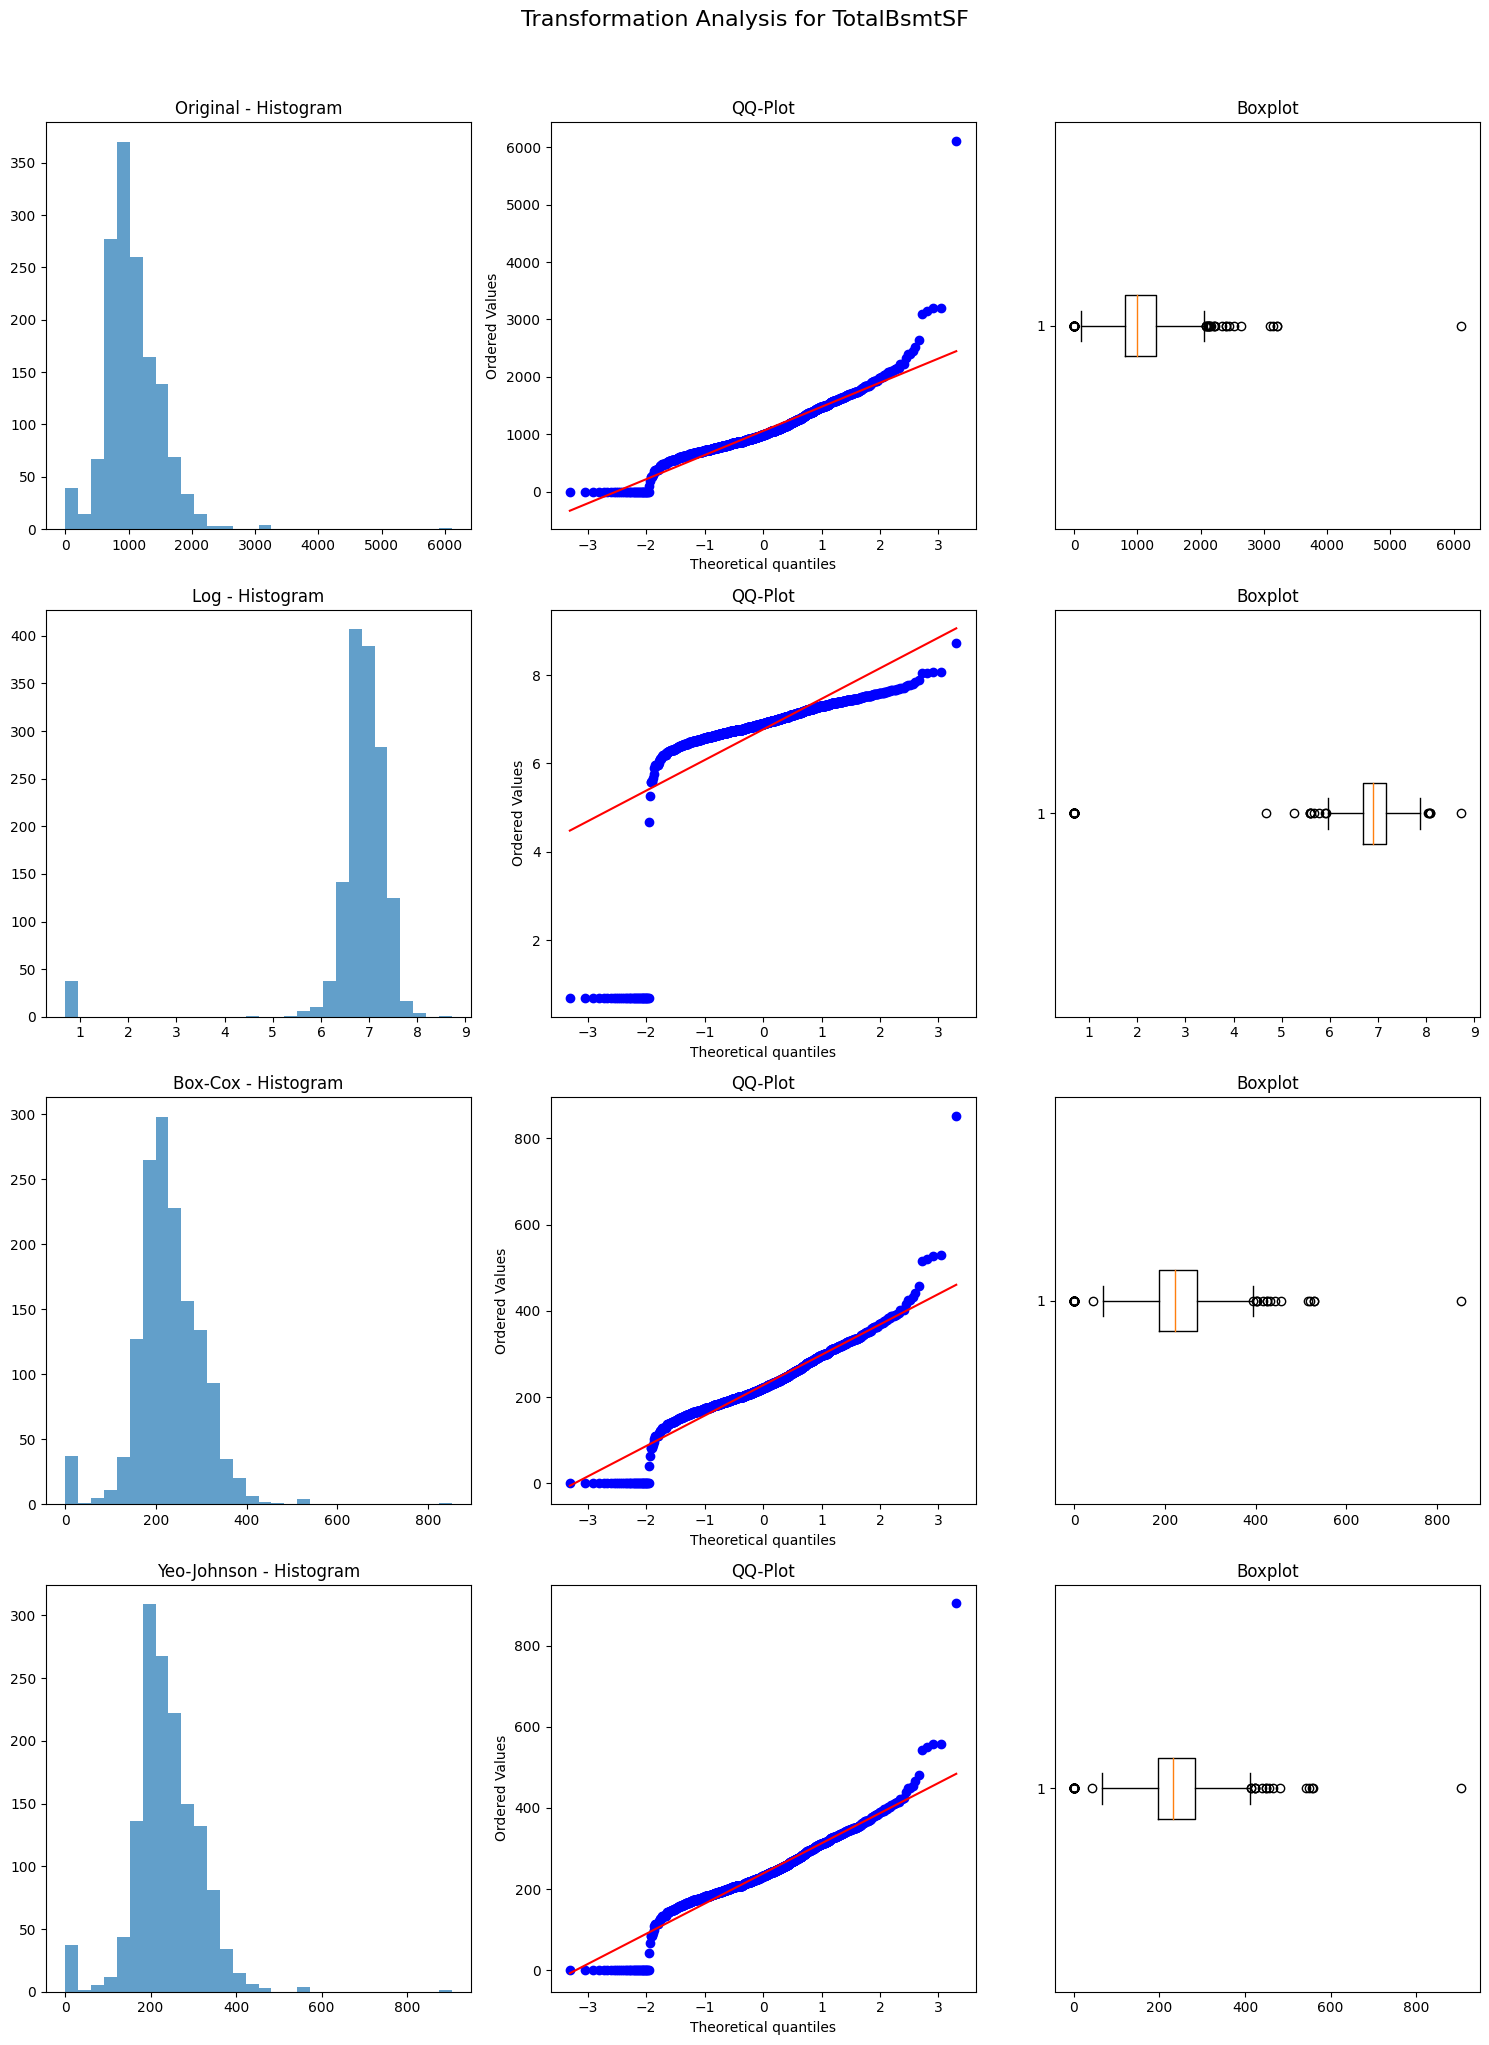

Analyzing transformations for: YearBuilt


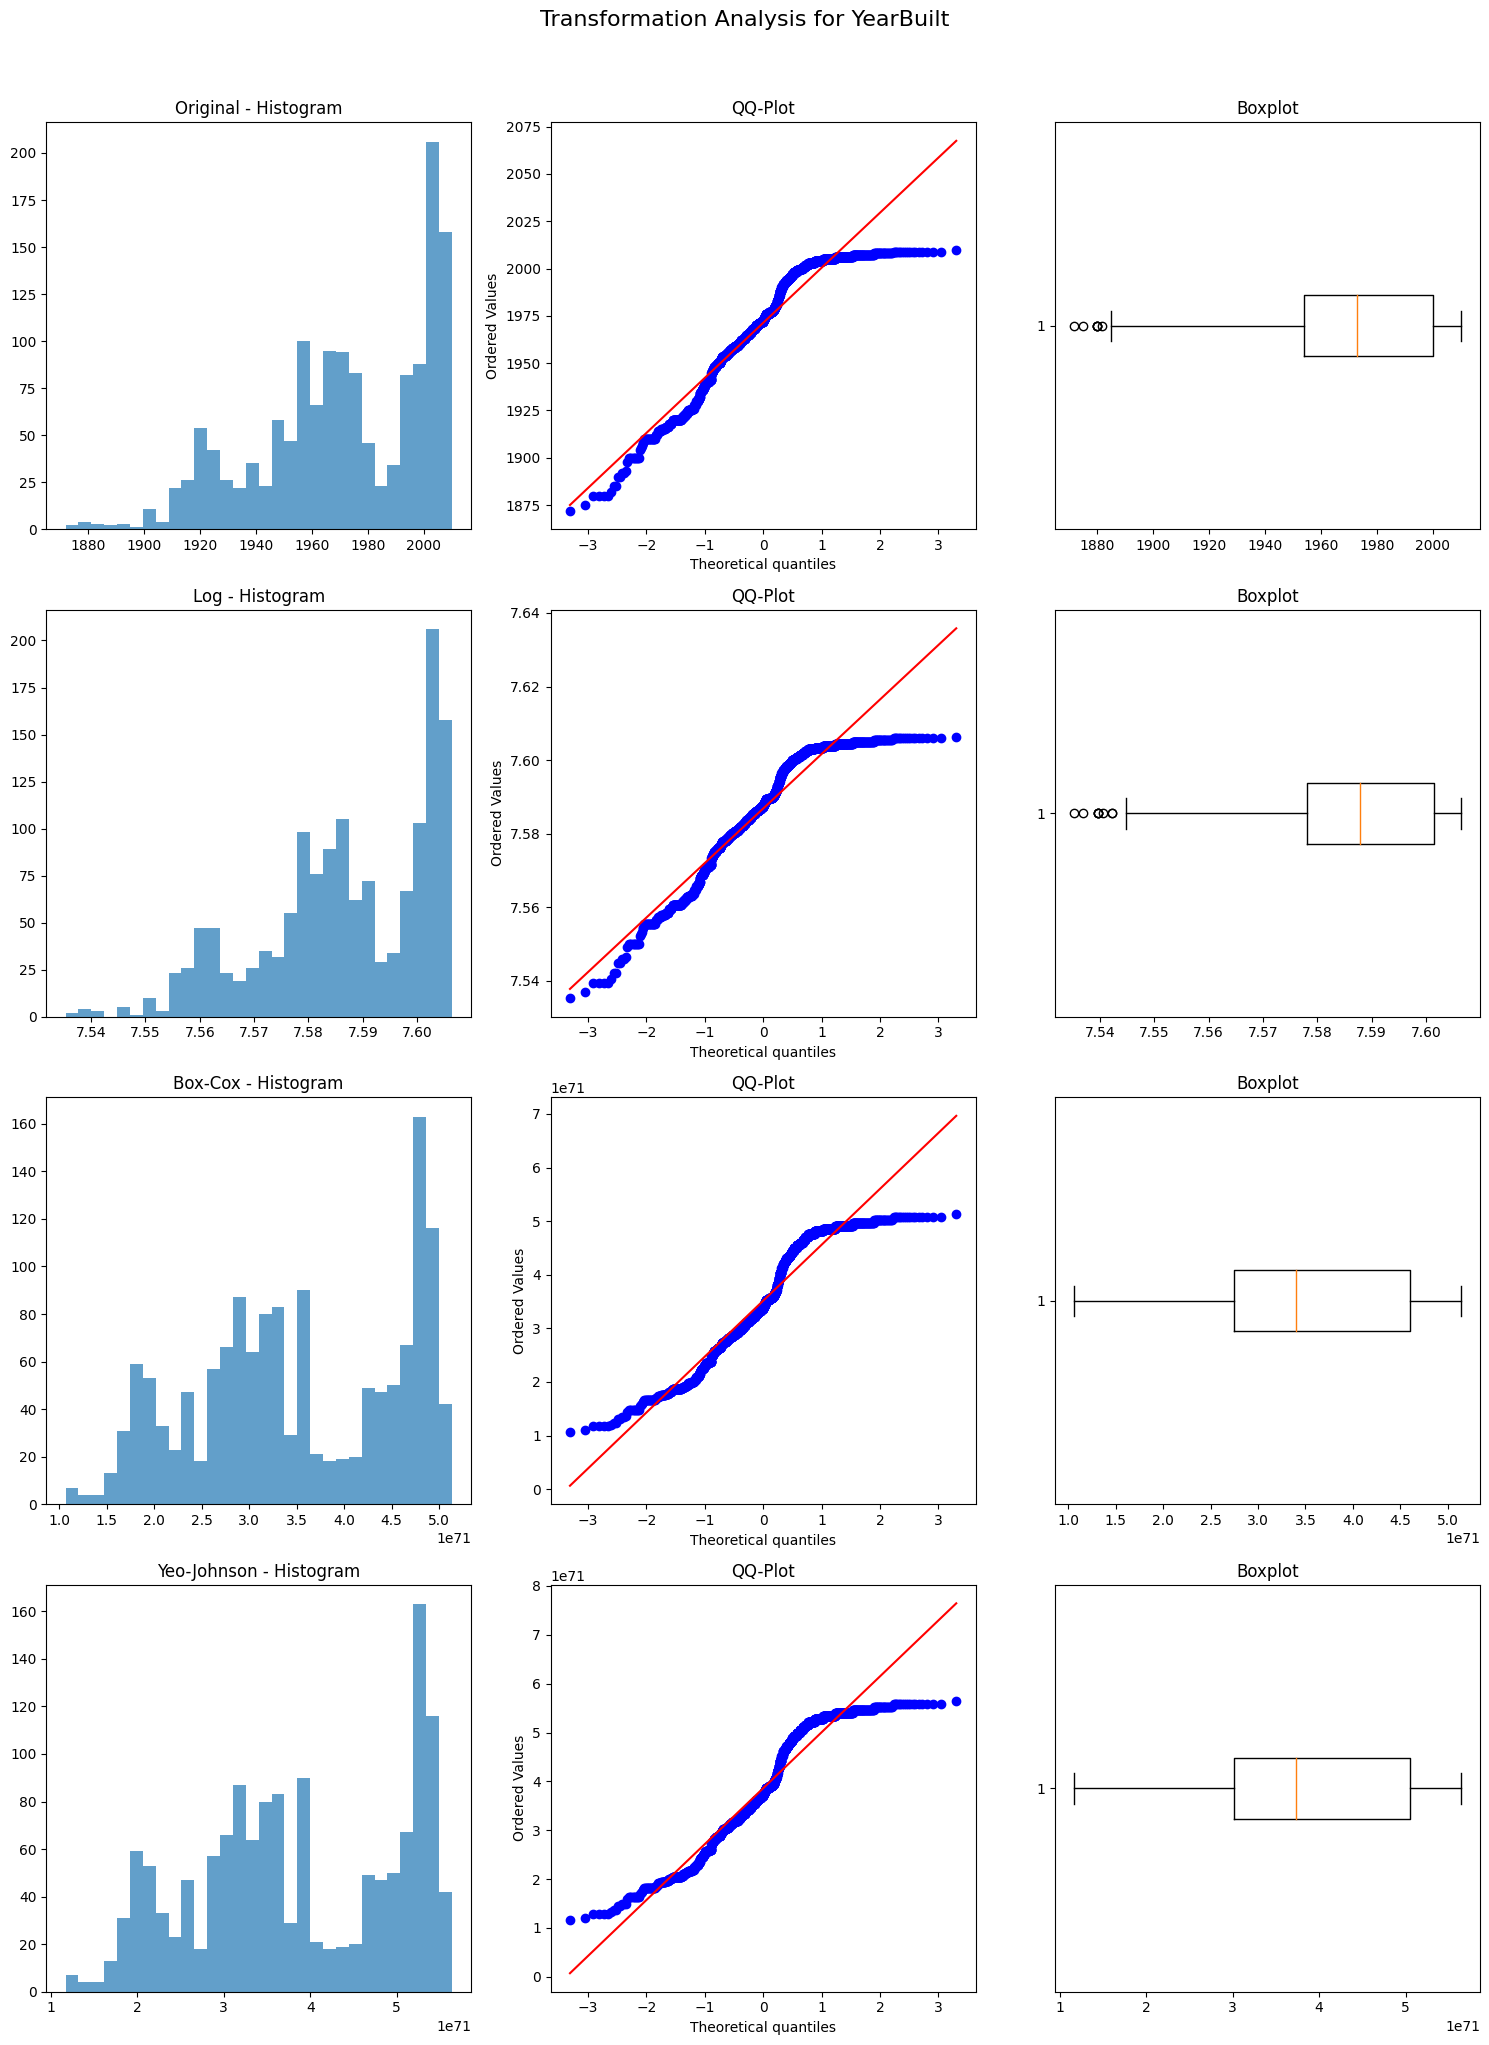

Analyzing transformations for: 1stFlrSF


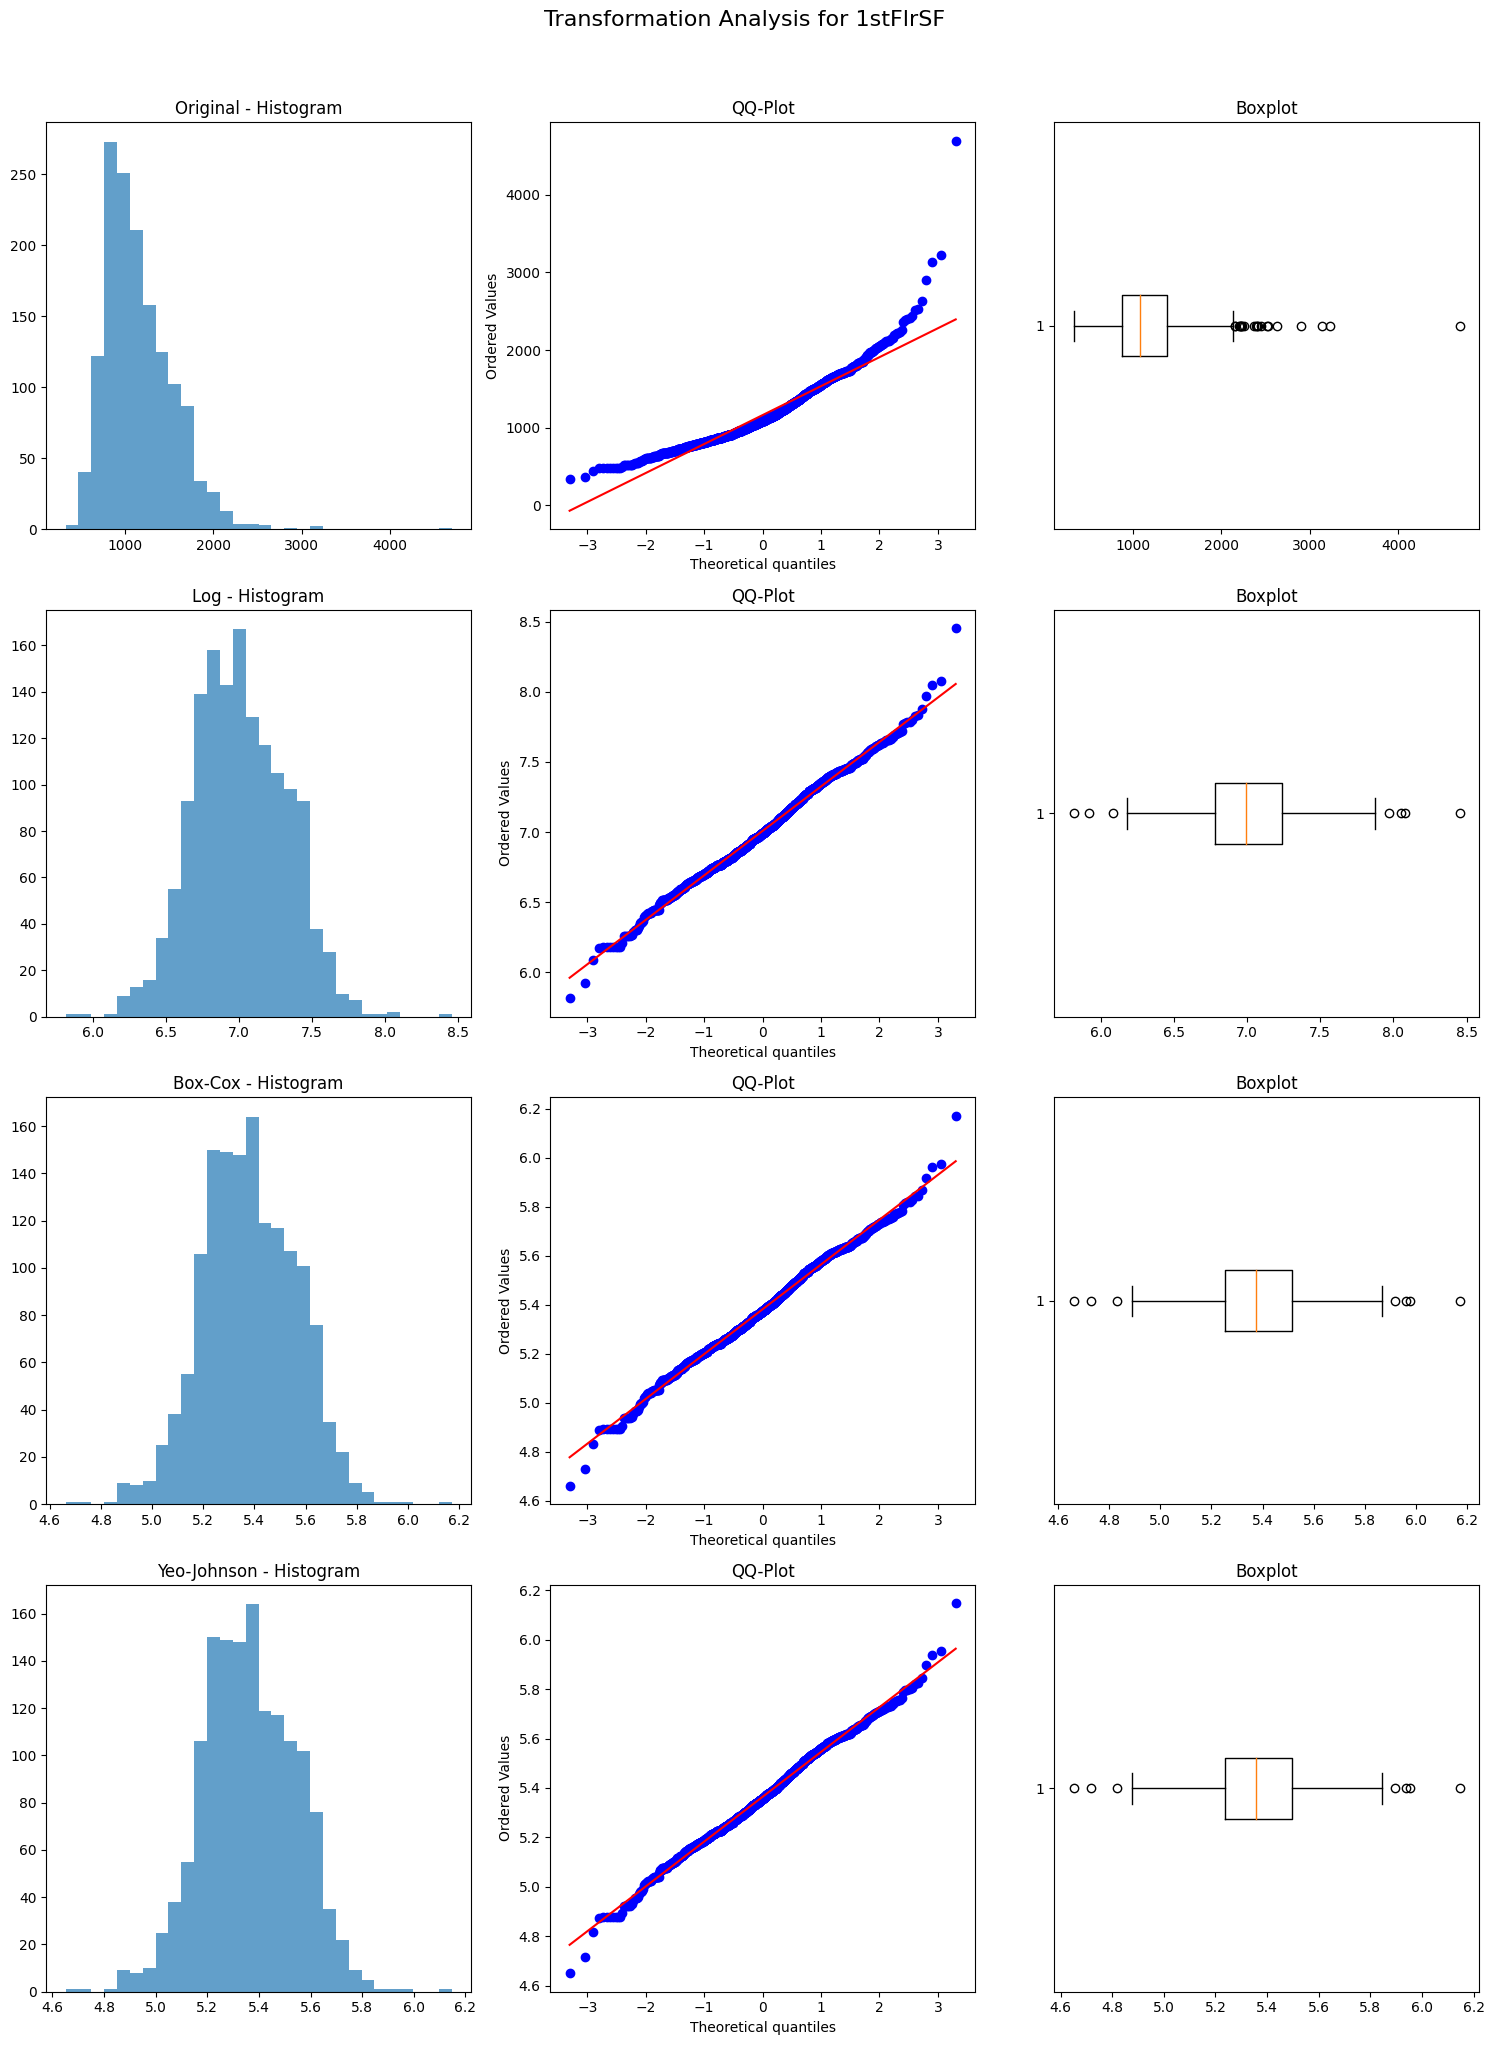

In [10]:
# Analyze transformations for strongly correlated variables
strong_corr_variables = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt','1stFlrSF']

for variable in strong_corr_variables:
    print(f"Analyzing transformations for: {variable}")
    compare_transformations(df_cleaned, variable)

**GrLivArea :**
Both Box-Cox and Yeo-Johnson transformations successfully normalize the GrLivArea variable, making it more suitable for modeling. Among these, Yeo-Johnson might be preferred for its flexibility with zeros or negative values, which are possible in other datasets.

**OverallQual:** 
This is a categorical variable representing house quality. Since it already has a discrete structure, transformations don’t improve it. I’m keeping it as is, as it provides meaningful levels directly to the model.

**GarageArea:** 
Yeo-Johnson or Box-Cox transformations are the best choices for GarageArea. Both effectively handle skewness and improve the data distribution, enhancing its usability for modeling.

**YearBuilt:** 
YearBuilt represents a temporal feature, so achieving normality may not be necessary.

**1stFlrSF:**
Both Box-Cox and Yeo-Johnson transformations are suitable for 1stFlrSF as they effectively reduce skewness and improve the variable's interpretability for the model.

___

##### **Filter Numeric Features for Correlation with SalePrice:**

Pick only numeric columns from the dataset.

Find the correlation between all numeric features and SalePrice.

Select features with a high correlation (above 0.5) to keep the strongest predictors.

##### **Prepare Features and Target:**

Use the highly correlated features to create X_combined.

Set y_combined as the target variable (SalePrice).

This step makes sure the model uses the most important predictors for better accuracy.

In [11]:
# Select only numeric columns from the cleaned DataFrame
df_cleaned_numeric = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = df_cleaned_numeric.corr()

# Identify features that have a high correlation with 'SalePrice'
threshold = 0.5
high_corr_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold].index.tolist()
print("Features with high correlation > 0.5:", high_corr_features)

# Create X_combined (features) with high correlation and y_combined ('SalePrice' target)
X_combined = df_cleaned_numeric[high_corr_features].drop(columns=['SalePrice'])
y_combined = df_cleaned_numeric['SalePrice']


Features with high correlation > 0.5: ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


___

##### **This code trains a RandomForestRegressor and finds the most important features using permutation importance.**

**Train the Model:**
The model is trained with X_combined (features) and y_combined (SalePrice).

**Feature Importance:**
Permutation importance measures how much each feature affects the model's predictions. Higher scores mean the feature is more important.

**Visualize Importance:**
A bar chart shows the importance of each feature to help identify the top predictors.

**Select Key Features:**
Features with importance greater than 0.03 are kept for further modeling.

This step helps the model focus on the most important predictors.

Feature importance:
        Feature  Importance
3   OverallQual    0.592013
2     GrLivArea    0.271733
4   TotalBsmtSF    0.095108
1    GarageArea    0.051410
6  YearRemodAdd    0.048048
0      1stFlrSF    0.042712
5     YearBuilt    0.040643


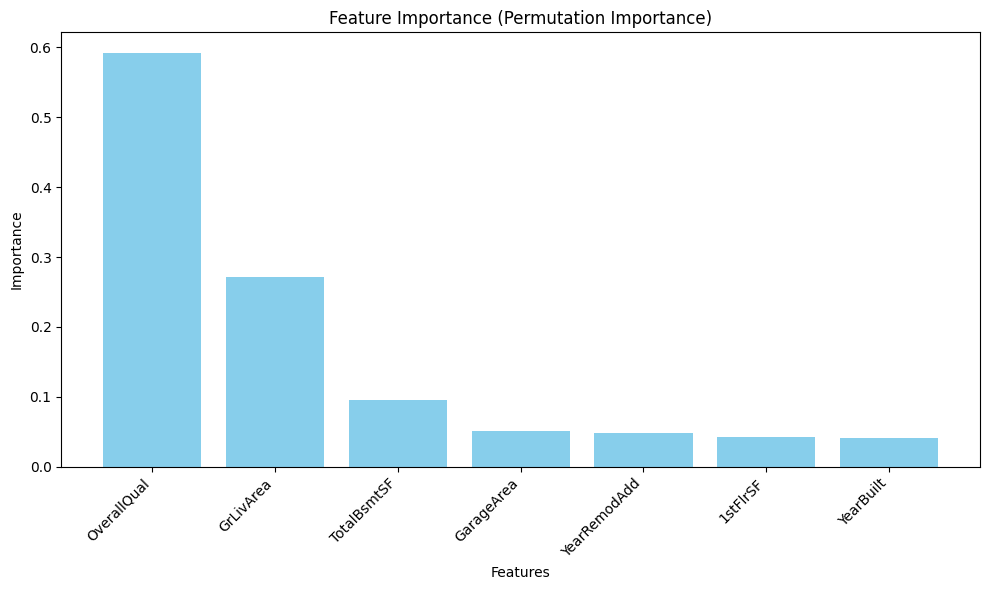

Selected features: ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearRemodAdd', '1stFlrSF', 'YearBuilt']


In [12]:
# Model training
model = RandomForestRegressor(random_state=42)
model.fit(X_combined, y_combined)

# Feature importance
perm_importance = permutation_importance(model, X_combined, y_combined, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Feature importance:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Select features with importance > 0.03
selected_features = importance_df[importance_df['Importance'] > 0.03]['Feature'].tolist()
print("Selected features:", selected_features)



##### **As we can see, the selected features are:**
**'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearRemodAdd', '1stFlrSF', 'YearBuilt'**,
which rank highest in feature importance.

Next, the correlation between these features will be checked to identify any overlap or redundancy.

___

##### **Inspect correlation between selected features**

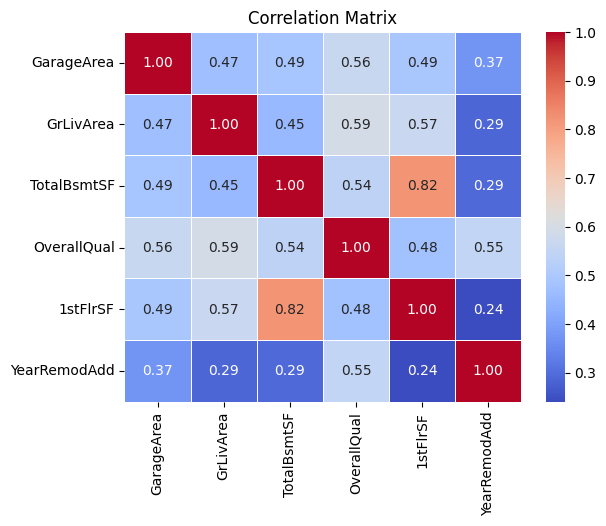

In [13]:
# Calculate and visualize the correlation matrix for the selected features
features_for_corr = ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', '1stFlrSF', 'YearRemodAdd']
corr_matrix = X_combined[features_for_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**1stFlrSF** is highly correlated with **TotalBsmtSF (0.82)**, and both have a correlation of **0.61** with **SalePrice**.
Since **TotalBsmtSF** has higher feature importance, **1stFlrSF** is excluded to avoid redundancy and multicollinearity.
___
Next, a new PNG image will be saved for use on the ML Summary page in the Streamlit app.

In [16]:
# Feature importance
perm_importance = permutation_importance(model, X_combined, y_combined, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)


top_5_features = importance_df.head(5)
print("Top 5 Feature importance:")
print(top_5_features)

filtered_df = importance_df[~importance_df['Feature'].isin(['1stFlrSF', 'YearBuilt'])]

plt.figure(figsize=(10, 6))
plt.bar(filtered_df['Feature'], filtered_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

# Save file
output_path = 'jupyter_notebooks/outputs/pipelines/feature_importance.png'
plt.savefig(output_path)
plt.close()
print(f"Feature importance plot saved successfully at {output_path}.")


Top 5 Feature importance:
        Feature  Importance
3   OverallQual    0.592013
2     GrLivArea    0.271733
4   TotalBsmtSF    0.095108
1    GarageArea    0.051410
6  YearRemodAdd    0.048048
Feature importance plot saved successfully at jupyter_notebooks/outputs/pipelines/feature_importance.png.


___

##### **This code defines the selected features for the pipeline, excluding features like **1stFlrSF** to avoid redundancy and prepare the cleaned DataFrame with only the selected features.**

**Create a transformation pipeline:**

* Apply Yeo-Johnson transformation to **GarageArea** to handle skewness.

* Scale **GrLivArea** and **TotalBsmtSF** to normalize their distributions.

* Pass **OverallQual** and **YearRemodAdd** without transformation, as they are categorical.

Train the pipeline on the selected features, excluding the target variable **SalePrice**.

Save the trained pipeline to a file for reuse during model deployment.
Save the pipeline's feature order to ensure the correct feature mapping is maintained.

**Outputs:**
* Trained pipeline saved at "outputs/pipelines/feature_pipeline_cleaned.pkl".
* Feature order saved at "outputs/pipelines/feature_order.txt".


In [19]:
# Define the functions used
selected_features = [
    'GarageArea',     # 1
    'GrLivArea',      # 2
    'TotalBsmtSF',    # 3
    'OverallQual',    # 4
    'YearRemodAdd',   # 5
    'SalePrice'
]
df_selected = df_cleaned[selected_features]

# Create the transformation pipeline
transformer = ColumnTransformer(
    transformers=[
        ('yeo_johnson', YeoJohnsonTransformer(variables=['GarageArea']), ['GarageArea']),
        ('scaler', StandardScaler(), ['GrLivArea', 'TotalBsmtSF']),
        ('passthrough', 'passthrough', ['OverallQual', 'YearRemodAdd'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# Create pipeline
pipeline = Pipeline([
    ('feature_transformation', transformer)
])

# Train the pipeline
pipeline.fit(df_selected.drop(columns=['SalePrice']))
print("Pipeline trained successfully.")

# Save the pipeline
pipeline_path = "jupyter_notebooks/outputs/pipelines/feature_pipeline_cleaned.pkl"
dump(pipeline, pipeline_path)
print(f"Pipeline saved successfully at {pipeline_path}")

pipeline_features = pipeline.named_steps['feature_transformation'].get_feature_names_out()
pipeline_features_cleaned = [feat.split('__')[-1] for feat in pipeline_features]
print("Final feature order from pipeline:", pipeline_features_cleaned)

# Save the feature order
feature_order_path = "jupyter_notebooks/outputs/pipelines/feature_order.txt"
with open(feature_order_path, "w") as f:
    for feature in pipeline_features_cleaned:
        f.write(feature + "\n")

print(f"Feature order saved successfully at {feature_order_path}")

Pipeline trained successfully.
Pipeline saved successfully at jupyter_notebooks/outputs/pipelines/feature_pipeline_cleaned.pkl
Final feature order from pipeline: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearRemodAdd']
Feature order saved successfully at jupyter_notebooks/outputs/pipelines/feature_order.txt


#### **Result:**
The pipeline was successfully trained on the selected features.

___

The selected features (excluding **SalePrice**) are transformed using the pipeline.

In [21]:
# Transform the dataset
X_transformed = pipeline.transform(df_selected.drop(columns=['SalePrice']))

df_transformed = pd.DataFrame(X_transformed, columns=pipeline_features_cleaned)

# Add target variable SalesPrice
df_transformed['SalePrice'] = df_selected['SalePrice'].values

# Check DataFrame
df_transformed.head()
df_transformed.info()

# Save the transformed dataset
output_path = "jupyter_notebooks/outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv"
df_transformed.to_csv(output_path, index=False)
print(f"Transformed dataset saved successfully at {output_path}.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageArea    1460 non-null   float64
 1   GrLivArea     1460 non-null   float64
 2   TotalBsmtSF   1460 non-null   float64
 3   OverallQual   1460 non-null   float64
 4   YearRemodAdd  1460 non-null   float64
 5   SalePrice     1460 non-null   float64
dtypes: float64(6)
memory usage: 68.6 KB
Transformed dataset saved successfully at jupyter_notebooks/outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv.


#### **Result:**
* The transformed dataset contains 1460 entries and 6 columns.

* All columns have non-null values, indicating no missing data in the transformed dataset.

* The data types for all columns are float64, suitable for numerical analysis and modeling.

* The dataset has been successfully saved at "outputs/datasets/collection/HousePricesPredictionFeatures.csv".

* Memory usage is low (68.6 KB), making it efficient for further processing.


___

##### Now the consistency between the pipeline and the dataset is validated to ensure the features used in the pipeline match exactly with the features in the transformed dataset (**HousePricesPredictionFeatures.csv**). Next a fresh correlation check is performed to ensure the chosen features are still the best.


In [23]:
# Load pipeline and dataset
pipeline = load("jupyter_notebooks/outputs/pipelines/feature_pipeline_cleaned.pkl")
df_transformed = pd.read_csv("jupyter_notebooks/outputs/datasets/collection/HousePricesPredictionFeatures_Cleaned.csv")

# Get pipeline features and remove prefix
pipeline_features = pipeline.named_steps['feature_transformation'].get_feature_names_out()
pipeline_features_cleaned = [feature.split('__')[-1] for feature in pipeline_features] 
print(f"Cleaned pipeline features: {pipeline_features_cleaned}")

# Get features in the dataset
dataset_features = df_transformed.drop(columns=['SalePrice']).columns.tolist()
print(f"Features in the dataset for prediction: {dataset_features}")

# Validate if features match
if pipeline_features_cleaned == dataset_features:
    print("Features match in the exact same order!")
else:
    print("Features mismatch (name or order)!")
    ...

# Correlation analysis
print("\nCorrelation with SalePrice (after feature engineering):")
correlation_with_saleprice = df_transformed.corr()['SalePrice'].sort_values(ascending=False)
print(correlation_with_saleprice)

Cleaned pipeline features: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearRemodAdd']
Features in the dataset for prediction: ['GarageArea', 'GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearRemodAdd']
Features match in the exact same order!

Correlation with SalePrice (after feature engineering):
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
TotalBsmtSF     0.613581
GarageArea      0.608821
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


**It is confirmed that both the feature names and their order are correct, which is important to avoid errors during model predictions.**

#### **Correlation Matrix After Feature Engineering**

The updated correlation matrix shows that feature engineering preserved the correlations between the features and the target variable **SalePrice**, confirming the strength of the selected features.

The selected features match perfectly between the pipeline and the dataset, with the same names and order. This ensures the pipeline is correctly aligned for predictions.

**OverallQual (0.79)** has the strongest correlation with SalePrice, showing that higher quality homes sell for more. It is the most important feature.

**GrLivArea (0.71)** and **TotalBsmtSF (0.61)** have strong positive correlations with SalePrice, making them key predictors of house prices.

**GarageArea (0.61)** also has a strong correlation with **SalePrice**, suggesting that properties with larger garages tend to sell for higher prices.

**YearRemodAdd (0.51)** has a moderate positive correlation, implying that houses that have been remodeled more recently tend to have higher values.

This confirms that the selected features are strong predictors of SalePrice and are ready for use in the model.

#### **Why These Features Were Selected:**

* Strong or moderate correlations with **SalePrice**.
* High feature importance scores in model analysis.
* Represent key details of a house, such as quality, size, and updates, which help predict house prices better.

Focusing on these features makes the model simpler and improves its accuracy by only using the most important predictors.

___

In [26]:
# Feature Engineering Summary
print("Feature Engineering Summary:")

# Count the total number of features before feature selection 
features_before_selection = len(df_cleaned.columns)
print(f"Total number of features before selection: {features_before_selection}")

# Ensure 'SalePrice' (target variable) is included in the selected features
if 'SalePrice' not in selected_features:
    selected_features.append('SalePrice')

# Count the total number of features after selection
features_after_selection = len(selected_features)
print(f"Total number of features after selection: {features_after_selection}")

# Calculate the number of features removed during selection
features_removed = features_before_selection - features_after_selection
print(f"Number of features removed: {features_removed}")

Feature Engineering Summary:
Total number of features before selection: 21
Total number of features after selection: 6
Number of features removed: 15


___

##### The following features were chosen because I thought they would have a strong correlation to SalePrice. These features represent important parts of a house, like size, quality, and improvements, which likely affect the selling price positive.

##### **Hypothesis 1**

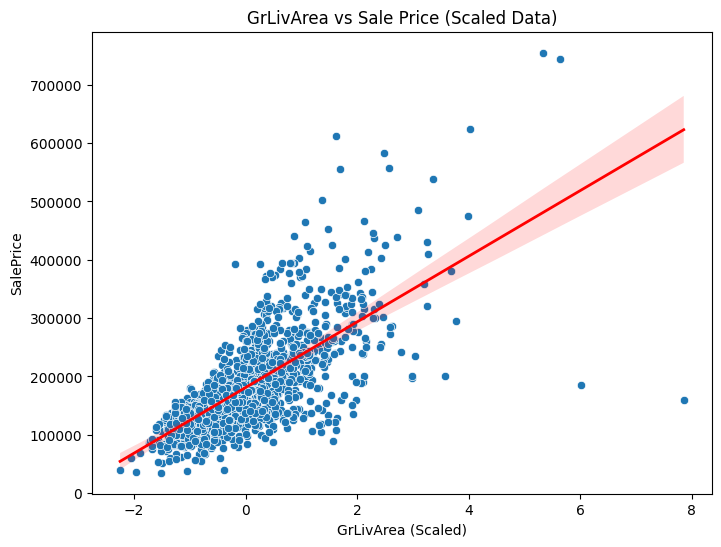

In [45]:
# Plot GrLivArea vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_transformed, alpha=1)
sns.regplot(x='GrLivArea', y='SalePrice', data=df_transformed, scatter=False, color='red', line_kws={"linewidth": 2})
plt.xlabel('GrLivArea (Scaled)')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price (Scaled Data)')
plt.show()

##### **Hypothesis 1 Confirmed**
The scatter plot and correlation analysis demonstrate a clear positive relationship between the total living area of a house and its sale price. This confirms the initial hypothesis that larger houses typically sell for higher prices.



___

##### **Hypothesis 2**

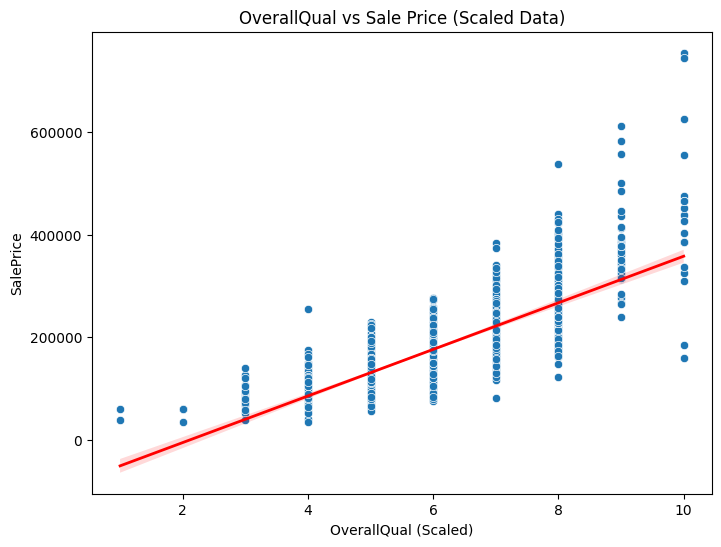

In [44]:
# Plot OverallQual vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df_transformed, alpha=1)
sns.regplot(x='OverallQual', y='SalePrice', data=df_transformed, scatter=False, color='red', line_kws={"linewidth": 2})
plt.xlabel('OverallQual (Scaled)')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price (Scaled Data)')
plt.show()

##### **Hypothesis 2 Confirmed**
The scatter plot and correlation analysis show a strong positive relationship between OverallQual and SalePrice. With a correlation of 0.79, higher-quality homes sell for more. This confirms that a home's quality has a big impact on its sale price.

___

##### **Hypothesis 3**

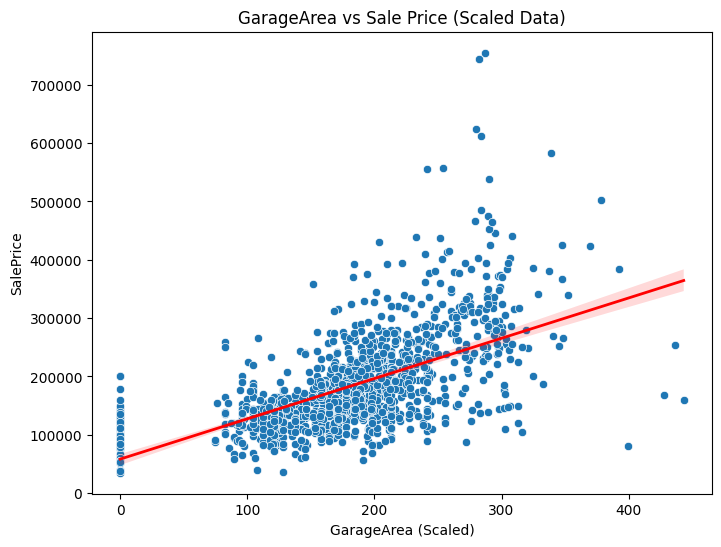

In [43]:
# Plot GarageArea vs SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=df_transformed, alpha=1)  # Justera alpha till 1 för starkare färg
sns.regplot(x='GarageArea', y='SalePrice', data=df_transformed, scatter=False, color='red', line_kws={"linewidth": 2}) 
plt.xlabel('GarageArea (Scaled)')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price (Scaled Data)')
plt.show()

##### **Hypothesis 3 Confirmed**
The scatter plot and correlation analysis show a clear positive relationship between GarageArea and SalePrice. This supports the hypothesis that houses with larger garages are likely to sell for higher prices. Additionally, some houses lack a garage, as shown by the cluster of points near a GarageArea value of 0.

___

### Feature Engineering Summary

* Features like **OverallQual (0.79)**, **GrLivArea (0.71)**, **TotalBsmtSF (0.61)** and **GarageArea (0.61)** are the best predictors of SalePrice.

* Even though **1stFlrSF** had a strong correlation with **SalePrice (0.61)**, it was removed due to its high correlation with **TotalBsmtSF (0.82)**, which could lead to multicollinearity. Instead, **YearRemodAdd (0.51)** was added because of its higher ranking in feature importance, indicating it contributes more to the model's predictive power.

* The initial dataset had 21 features, which have been reduced to 6 key features after selection.

* A total of 15 features were removed, ensuring the final dataset is simpler and focused on the most predictive attributes.

* Hypotheses 1, 2, and 3 were confirmed, visualized, and documented in the README.

* The final dataset is ready for modeling, with selected features strongly linked to **SalePrice**. All features have been cleaned, transformed, and prepared for model training.

### Next step

Now that the dataset is prepared, the next step is to build and evaluate a model in a separate notebook **HouseSalePrices.ipynb**. **HousePricesPredictionFeatures_Cleaned.csv** file will be loaded, and various regression models will be tested, cross-validation performed, and performance assessed before optimization.